# Dataset: facial expression

- https://github.com/muxspace/facial_expressions
- https://www.kaggle.com/c/emotion-detection-from-facial-expressions

In [1]:
import keras
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import skimage as ski
import skimage.io
import skimage.transform
import skimage.util
from keras.callbacks import TensorBoard
from time import time
import os

%matplotlib inline

/Users/abulbasar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
root_path = "/data/kaggle/face-emotion/facial_expressions-master/"
files = os.listdir(root_path + "/images")
len(files)

13718

In [3]:
legends = pd.read_csv(root_path + "data/legend.csv")
legends.drop_duplicates("image", inplace=True)
legends["emotion"] = legends.emotion.apply(lambda v: v.upper())
legends.head()

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,ANGER
1,628,facial-expressions_2868585k.jpg,SURPRISE
2,628,facial-expressions_2868584k.jpg,DISGUST
3,628,facial-expressions_2868582k.jpg,FEAR
4,dwdii,Aaron_Eckhart_0001.jpg,NEUTRAL


In [4]:
legends.emotion.value_counts()/len(legends)

NEUTRAL      0.501681
HAPPINESS    0.416094
SURPRISE     0.026897
SADNESS      0.019515
ANGER        0.018418
DISGUST      0.015202
FEAR         0.001535
CONTEMPT     0.000658
Name: emotion, dtype: float64

In [5]:
emotion_by_file = dict(legends.set_index("image").emotion)
str(emotion_by_file)[:100]

"{'facial-expressions_2868588k.jpg': 'ANGER', 'facial-expressions_2868585k.jpg': 'SURPRISE', 'facial-"

In [6]:
pd.Series(emotion_by_file).value_counts()

NEUTRAL      6864
HAPPINESS    5693
SURPRISE      368
SADNESS       267
ANGER         252
DISGUST       208
FEAR           21
CONTEMPT        9
dtype: int64

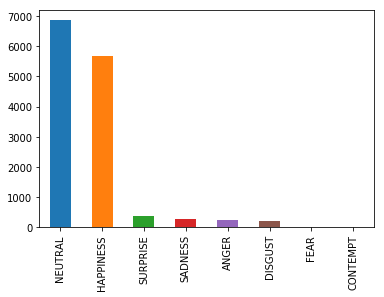

In [7]:
legends.emotion.value_counts().plot.bar()

Find intersetion between set of file names present in the images directory and that are labeled

In [8]:
files_confirmed = dict([(fname, emotion_by_file[fname]) for fname in files if fname in emotion_by_file])
filenames_confirmed = list(files_confirmed.keys())
len(filenames_confirmed)

13681

In [23]:
def get_file_path(fname, subdir = "images"):
    return os.path.join(root_path, subdir, fname)

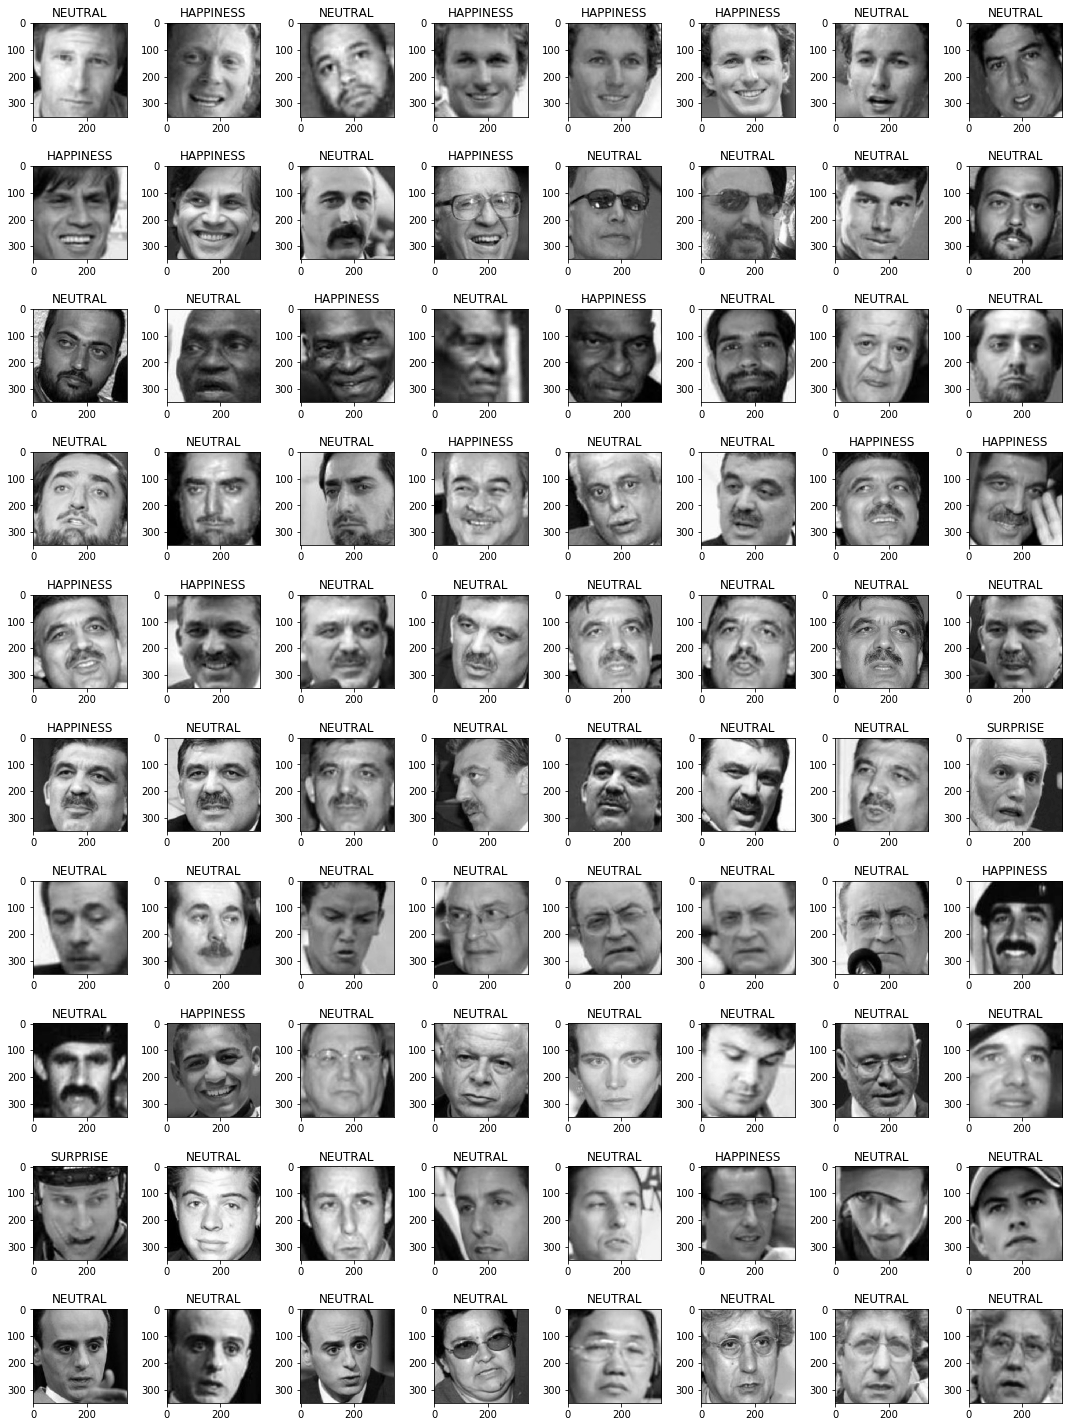

In [10]:
fig, _ = plt.subplots(10, 8, figsize = (15, 20))
for i, ax in enumerate(fig.axes):
    fname = filenames_confirmed[i]
    img = ski.io.imread(get_file_path(fname))
    ax.imshow(img, cmap= "gray")
    ax.set_title(emotion_by_file[fname])
    
plt.tight_layout()

In [11]:
emotions = legends.emotion.unique()
emotions

array(['ANGER', 'SURPRISE', 'DISGUST', 'FEAR', 'NEUTRAL', 'HAPPINESS',
       'SADNESS', 'CONTEMPT'], dtype=object)

In [12]:
emotion_idx_by_value = dict([(v, i) for i, v in enumerate(emotions)])
emotion_idx_by_value

{'ANGER': 0,
 'SURPRISE': 1,
 'DISGUST': 2,
 'FEAR': 3,
 'NEUTRAL': 4,
 'HAPPINESS': 5,
 'SADNESS': 6,
 'CONTEMPT': 7}

In [13]:
img_data = []
y = []
for fname in files_confirmed:
    path = get_file_path(fname)        
    img = ski.io.imread(path)
    img_data.append(img)
    emotion = emotion_by_file[fname]
    y.append(emotion_idx_by_value[emotion])

In [14]:
img_data_3_channel = [img.reshape(* img.shape, 1) if len(img.shape) == 2 else img for img in img_data]
shapes = np.array([img.shape for img in img_data_3_channel])
np.min(shapes, axis = 0)

array([24, 18,  1])

In [15]:
img_data_resized = []
for img in img_data:
    if len(img.shape) == 3:
        img = ski.color.rgb2gray(img)
    img = ski.transform.resize(img,  (28, 28), mode = "reflect")
    img_data_resized.append(img)

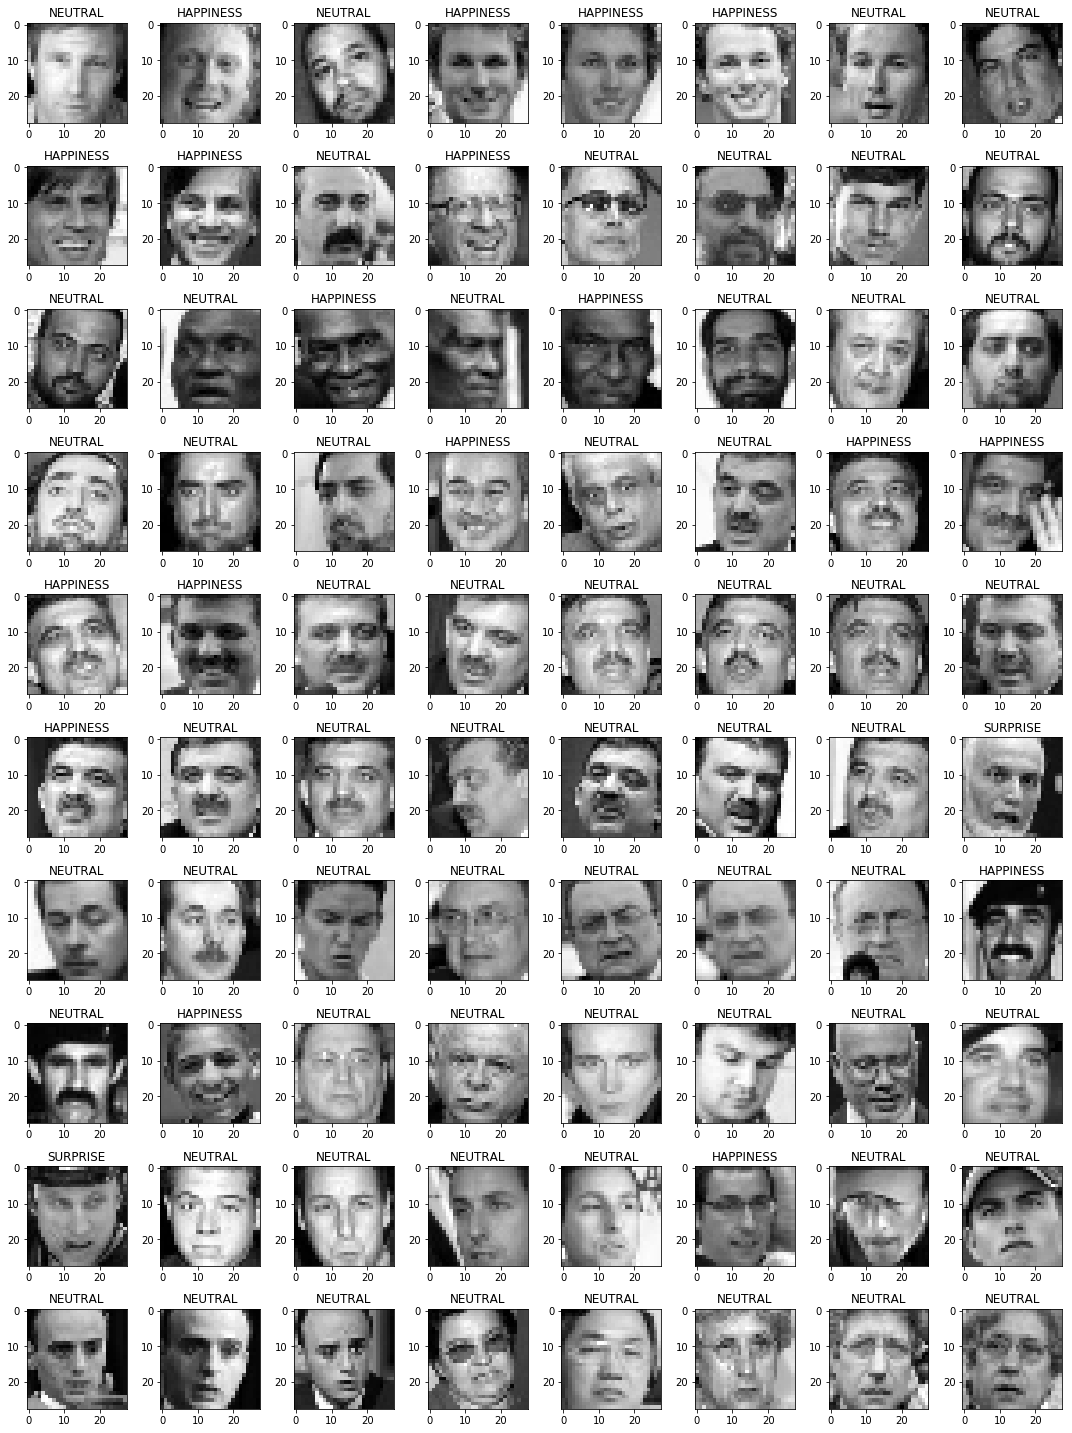

In [16]:
fig, _ = plt.subplots(10, 8, figsize = (15, 20))
for i, ax in enumerate(fig.axes):
    fname = filenames_confirmed[i]
    img = img_data_resized[i]
    ax.imshow(img, cmap= "gray")
    ax.set_title(emotion_by_file[fname])
    
plt.tight_layout()

In [17]:
pd.Series([img.shape for img in img_data_resized]).unique()

array([(28, 28)], dtype=object)

In [18]:
X = np.array(img_data_resized).reshape(-1, 28, 28, 1)/255
Y = keras.utils.to_categorical(np.array(y))

In [19]:
X.shape, Y.shape

((13681, 28, 28, 1), (13681, 8))

In [20]:
input_shape = (28, 28, 1)
n_classes = len(np.unique(y))

model = keras.Sequential()
model.add(Conv2D(32, (5, 5), activation="relu", input_shape = input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(400, activation="relu"))
model.add(Dense(n_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer="adam")


In [21]:
tboard = TensorBoard(log_dir="/tmp/tf/log/%d" % time())
model.fit(X, Y
          , epochs=20
          , batch_size=32
          , validation_split=0.2
          , callbacks = [tboard]
         )

Train on 10944 samples, validate on 2737 samples
Epoch 1/20
10944/10944 [==============================] - 14s 1ms/step - loss: 1.0985 - acc: 0.4861 - val_loss: 0.9708 - val_acc: 0.4962
Epoch 2/20
10944/10944 [==============================] - 14s 1ms/step - loss: 1.0613 - acc: 0.4933 - val_loss: 0.9574 - val_acc: 0.4962
Epoch 3/20
10944/10944 [==============================] - 14s 1ms/step - loss: 1.0531 - acc: 0.4975 - val_loss: 0.9765 - val_acc: 0.4962
Epoch 4/20
10944/10944 [==============================] - 14s 1ms/step - loss: 1.0463 - acc: 0.4984 - val_loss: 0.9656 - val_acc: 0.5148
Epoch 5/20
10944/10944 [==============================] - 14s 1ms/step - loss: 1.0258 - acc: 0.5187 - val_loss: 0.9254 - val_acc: 0.5681
Epoch 6/20
10944/10944 [==============================] - 15s 1ms/step - loss: 0.9586 - acc: 0.6065 - val_loss: 0.7891 - val_acc: 0.7176
Epoch 7/20
10944/10944 [==============================] - 14s 1ms/step - loss: 0.8768 - acc: 0.6721 - val_loss: 0.7549 - val_acc:

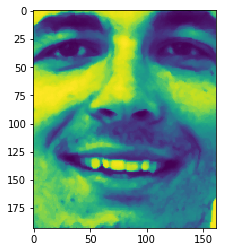

In [86]:
test_img = ski.io.imread("/data/kaggle/face-emotion/test/18b.jpg")
plt.imshow(test_img)

In [87]:
test_img.shape

(193, 162)

Size (28, 28)


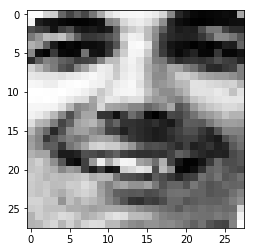

In [88]:
test_image_reshaped = None 
if len(test_img.shape) == 2:
    test_image_reshaped = ski.transform.resize(test_img, (28, 28), mode = "reflect")
else:
    test_image_reshaped = ski.transform.resize(test_img, (28, 28, 3), mode = "reflect")
    test_image_reshaped = ski.color.rgb2gray(test_image_reshaped)

print("Size", test_image_reshaped.shape)
plt.imshow(test_image_reshaped, cmap="gray")

In [89]:
emotions[model.predict_classes(test_image.reshape(1, 28, 28, 1))]

array(['HAPPINESS'], dtype=object)